In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

In [9]:
def get_error_plot_by_params(X_train, X_test, y_train, y_test, param, max_param, n_trees=50, max_depth=5, coef=1, eta=0.1):
    
    coefs = [coef] * n_trees
    x = []
    plt.xlabel(param)
    plt.ylabel('MSE')
    
    if param == 'max_trees':
        for tree in range(1, max_param + 1):
            coefs = [coef] * tree
            trees, train_errors, test_errors = gb_fit(tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
            x.append((train_errors[-1], test_errors[-1]))
    elif param=='max_depth':
        for depth in range(1, max_param + 1):
            trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
            x.append((train_errors[-1], test_errors[-1]))
    
    plt.plot(range(1, max_param + 1), [itm[0] for itm in x], label='train error')
    plt.plot(range(1, max_param + 1), [itm[1] for itm in x], label='test error')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

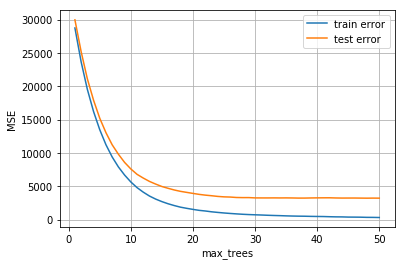

In [10]:
get_error_plot_by_params(X_train, X_test, y_train, y_test, param='max_trees', max_param=50)

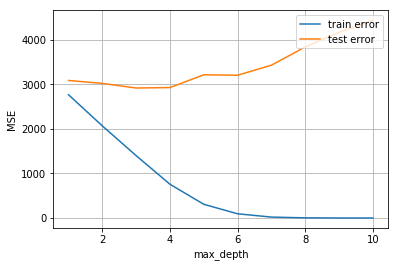

In [11]:
get_error_plot_by_params(X_train, X_test, y_train, y_test, param='max_depth', max_param=10)

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [12]:
def gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sub_coef=0.5):
    
    # Деревья будем записывать в список
    trees = []
    # Количество элементов в подвыборке
    len_x = len(X_train)
    n_subsample = round(len_x*sub_coef)
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        # Собираем подвыборки
        idxs = np.random.choice(range(len_x), n_subsample, replace=False)
        X_train_sub = [X_train[idx] for idx in idxs]
        y_train_sub = [y_train[idx] for idx in idxs]

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_sub, y_train_sub)
            
            train_errors.append(mean_squared_error(y_train_sub, gb_predict(X_train_sub, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_sub, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_sub, bias(y_train_sub, target))
            
            train_errors.append(mean_squared_error(y_train_sub, gb_predict(X_train_sub, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [13]:
def get_error_plot_by_iter(X_train, X_test, y_train, y_test, n_trees=100, max_depth=5, coef=1, eta=0.1):
    
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    
    coefs = [coef] * n_trees
    
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth,
                                              X_train, X_test,
                                              y_train, y_test,
                                              coefs, eta)
    trees_st, train_errors_st, test_errors_st = gb_fit_stochastic(n_trees, max_depth,
                                                                  X_train, X_test,
                                                                  y_train, y_test,
                                                                  coefs, eta, sub_coef=0.5)
    
    plt.plot(list(range(n_trees)), test_errors, label='test error GBM')
    plt.plot(list(range(n_trees)), test_errors_st, label='test error SGBM')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

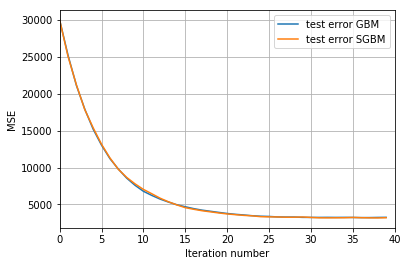

In [14]:
get_error_plot_by_iter(X_train, X_test, y_train, y_test, n_trees=40, max_depth=5, coef=1, eta=0.1)